# MLP Model

In [63]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
from torch import nn,functional
import torchvision
from torchvision import datasets,transforms
device = torch.device("cuda:4" if torch.cuda.is_available else "cpu")

from sklearn.model_selection import train_test_split

%matplotlib inline

In [64]:
train_batch_size =100
test_batch_size =100

In [65]:

#Loading data
train = pd.read_csv("./input/train.csv")
X = train.loc[:,train.columns != "label"].values/255   #Normalizing the values
Y = train.label.values

features_train, features_test, targets_train, targets_test = train_test_split(X,Y,test_size=0.2,random_state=42)
X_train = torch.from_numpy(features_train).to(device)
X_test = torch.from_numpy(features_test).to(device)

Y_train = torch.from_numpy(targets_train).type(torch.LongTensor).to(device)
Y_test = torch.from_numpy(targets_test).type(torch.LongTensor).to(device)

train = torch.utils.data.TensorDataset(X_train,Y_train)
test = torch.utils.data.TensorDataset(X_test,Y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = train_batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = test_batch_size, shuffle = False)


In [66]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        
        self.fc1=nn.Linear(28*28,256)        
        self.drop1=nn.Dropout(p=0.3)
        self.relu1=nn.ReLU()
        
        self.fc2=nn.Linear(256,64)
        self.drop2=nn.Dropout(p=0.3)
        self.relu2=nn.ReLU()
        
        self.fc3 = nn.Linear(64,10)         
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        
        x = x.view(x.size(0), -1)
        
        out = self.fc1(x)
        out = self.drop1(out)
        out = self.relu1(out)
        
        out = self.fc2(out)
        out = self.drop2(out)
        out = self.relu2(out)

        out = self.fc3(out)        
        out = self.softmax(out)
        return out
        

In [67]:
model = MLP()
model = model.double()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.1, momentum=0.8)

In [68]:
epochs = 15
train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    
    for images,labels in train_loader:
        #train = Variable(images.view(-1,1,28,28))
        train=images.view(-1,1,28,28)
        #labels = Variable(labels)
        
        optimizer.zero_grad()
        
        output = model(train)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for images,labels in test_loader:
                
                test=images.view(-1,1,28,28)
        
                log_ps = model(test)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/15..  Training Loss: 1.976..  Test Loss: 1.674..  Test Accuracy: 0.798
Epoch: 2/15..  Training Loss: 1.619..  Test Loss: 1.561..  Test Accuracy: 0.905
Epoch: 3/15..  Training Loss: 1.567..  Test Loss: 1.543..  Test Accuracy: 0.920
Epoch: 4/15..  Training Loss: 1.548..  Test Loss: 1.530..  Test Accuracy: 0.934
Epoch: 5/15..  Training Loss: 1.536..  Test Loss: 1.524..  Test Accuracy: 0.940
Epoch: 6/15..  Training Loss: 1.526..  Test Loss: 1.519..  Test Accuracy: 0.944
Epoch: 7/15..  Training Loss: 1.522..  Test Loss: 1.513..  Test Accuracy: 0.950
Epoch: 8/15..  Training Loss: 1.515..  Test Loss: 1.510..  Test Accuracy: 0.954
Epoch: 9/15..  Training Loss: 1.512..  Test Loss: 1.507..  Test Accuracy: 0.956
Epoch: 10/15..  Training Loss: 1.508..  Test Loss: 1.504..  Test Accuracy: 0.958
Epoch: 11/15..  Training Loss: 1.504..  Test Loss: 1.501..  Test Accuracy: 0.961
Epoch: 12/15..  Training Loss: 1.503..  Test Loss: 1.500..  Test Accuracy: 0.961
Epoch: 13/15..  Training Loss: 1.501.

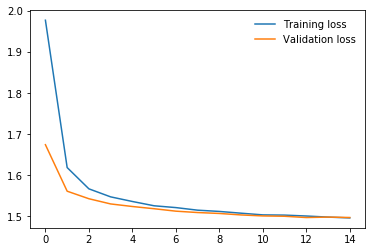

In [69]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
#plt.plot(accuracy, label='Validation accu')

plt.legend(frameon=False)

In [70]:
test_images = pd.read_csv("./input/test.csv")
test_image = test_images.loc[:,test_images.columns != "label"].values/255
test_dataset = torch.from_numpy(test_image).to(device)
new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [71]:
top_classes = []
with torch.no_grad():
    model.eval()
    
    for images in new_test_loader:
        test = images.view(-1,1,28,28).to(device)
        output = model(test)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim = 1)
        top_classes.append(int(top_class))

In [72]:
predlabel = top_classes
predictions = np.array(predlabel)


In [73]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("./output/my_submissions_mlp.csv", index=False, header=True)